In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
df = pd.read_csv("Police_Response_to_Resistance___2019.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBJECTID          2944 non-null   int64  
 1   ZIP               2943 non-null   float64
 2   FILENUM           2944 non-null   object 
 3   UOFNum            2944 non-null   object 
 4   OCCURRED_D        2944 non-null   object 
 5   OCCURRED_T        2931 non-null   object 
 6   CURRENT_BA        2944 non-null   int64  
 7   OffSex            2944 non-null   object 
 8   OffRace           2944 non-null   object 
 9   HIRE_DT           2944 non-null   object 
 10  OFF_INJURE        2944 non-null   bool   
 11  OffCondTyp        2944 non-null   object 
 12  OFF_HOSPIT        2944 non-null   bool   
 13  SERVICE_TY        2937 non-null   object 
 14  ForceType         2944 non-null   object 
 15  UOF_REASON        2937 non-null   object 
 16  Cycles_Num        174 non-null    object 


In [4]:
df.head()

,OBJECTID,ZIP,FILENUM,UOFNum,OCCURRED_D,OCCURRED_T,CURRENT_BA,OffSex,OffRace,HIRE_DT,...,CIT_INFL_A,CitChargeT,Council District,RA,BEAT,SECTOR,DIVISION,X,Y,GeoLocation
0,2817,75253.0,UF2019-1702,"62295, 63542",12/01/2019,10:34 PM,11285,Male,White,03/08/2017,...,Agitated,No Arrest,D8,6062.0,357.0,350.0,SOUTHEAST,2557123.437,6944231.397,POINT (-96.586265 32.702825)
1,2234,75208.0,UF2019-1344,61093,10/06/2019,12:50 AM,11208,Male,White,08/24/2016,...,Agitated,APOWW,D1,4160.0,444.0,440.0,SOUTHWEST,2474936.793,6952151.398,POINT (-96.853036 32.729136)
2,2755,75231.0,UF2019-1665,62820,12/31/2019,11:37 PM,9415,Male,White,04/02/2008,...,Poor hygiene,"Burglary/Habitation, Warrant/Hold",D9,6034.0,247.0,240.0,NORTHEAST,2508349.267,7001784.466,POINT (-96.741661 32.863941)
3,2110,75228.0,UF2019-1314,60990,09/30/2019,6:20 PM,9884,Male,Hispanic,06/10/2009,...,Unknown Drugs,"Assault/FV, Resisting Arrest, Warrant/Hold",D9,1132.0,228.0,220.0,NORTHEAST,2536678.324,6999039.025,POINT (-96.649175 32.855492)
4,1663,75051.0,UF2019-1030,"59592, 59600",08/04/2019,12:10 AM,10480,Male,Hispanic,09/26/2012,...,Agitated,Assault/Public Servant,NaN,NaN,NaN,NaN,NaN,2433285.622,6953645.720,POINT (-96.98722 32.734935)


### Table for database

In [5]:
table1 = df[['FILENUM', 'UOFNum', 'ForceEffec', 'ForceType']]
table1.head()

,FILENUM,UOFNum,ForceEffec,ForceType
0,UF2019-1702,"62295, 63542","Yes, Yes","BD - Tripped, BD - Grabbed"
1,UF2019-1344,61093,Yes,Held Suspect Down
2,UF2019-1665,62820,Yes,K-9 Deployment
3,UF2019-1314,60990,Yes,Joint Locks
4,UF2019-1030,"59592, 59600","Yes, Yes","Joint Locks, BD - Grabbed"


In [6]:
for x, y, z in zip(df.UOFNum, df.ForceEffec, df.ForceType):
    if len(x.split(",")) == len(y.split(",")) and len(y.split(",")) == len(z.split(",")):
        pass
    else:
        print("False")

In [18]:
def expand_record(record, lst_appnd):
    global commas
    global n
    commas = False
    if "," in record:
        x = record.split(",")
        for y in x:
            lst_appnd.append(y.lstrip())
        commas = True
        n = len(x)
    else:
        lst_appnd.append(record)

In [19]:
filenum = []
uofnum = []
forceeffec = []
forcetype = []
for fno, uof, foreffc, fortyp in zip(df.FILENUM, df.UOFNum, df.ForceEffec, df.ForceType):
    expand_record(uof, uofnum)
    if commas == True:
        for nn in range(n):
            filenum.append(fno)
        commas = False
    else:
        filenum.append(fno)
    expand_record(foreffc, forceeffec)
    expand_record(fortyp, forcetype)

In [25]:
data = {'FILENUM':filenum, 'UOFNum':uofnum, 'ForceEffec':forceeffec, 'ForceType':forcetype}
table1 = pd.DataFrame(data)
table1.head()

,FILENUM,UOFNum,ForceEffec,ForceType
0,UF2019-1702,62295,Yes,BD - Tripped
1,UF2019-1702,63542,Yes,BD - Grabbed
2,UF2019-1344,61093,Yes,Held Suspect Down
3,UF2019-1665,62820,Yes,K-9 Deployment
4,UF2019-1314,60990,Yes,Joint Locks


### Misc. exploration

In [4]:
df.CitRace.value_counts(normalize=True)

Black           0.539917
Hispanic        0.226084
White           0.220234
Asian           0.006194
Other           0.003785
American Ind    0.002409
Unknown         0.001376
Name: CitRace, dtype: float64

In [5]:
df.CIT_INJURE.value_counts()

False    2259
True      685
Name: CIT_INJURE, dtype: int64

In [6]:
freq = []
for x in df.ForceType:
    if "," in x:
        y = x.split(",")
        for z in y:
            freq.append(z.lstrip())
    else:
        freq.append(x)

In [7]:
freq_dict = (pd.Series(freq).value_counts()).to_dict()

In [8]:
freq_dict

{'Verbal Command': 1235,
 'Held Suspect Down': 848,
 'Foot Pursuit': 693,
 'Weapon display at Person': 548,
 'BD - Grabbed': 481,
 'Take Down - Body': 303,
 'Joint Locks': 297,
 'Hand Controlled Escort': 268,
 'Take Down - Arm': 262,
 'Taser': 195,
 'BD - Pushed': 168,
 'Hand/Arm/Elbow Strike': 161,
 'Taser Display at Person': 159,
 'Handcuffing Take Down': 145,
 'Feet/Leg/Knee Strike': 105,
 'Pressure Points': 79,
 'BD - Tripped': 77,
 'Take Down - Head': 53,
 'Take Down - Group': 49,
 'OC Spray': 40,
 'Leg Restraint System': 33,
 'K-9 Deployment': 20,
 '40mm Less Lethal': 11,
 'Other Impact Weapon': 5,
 'Combat Stance': 5,
 'LVNR': 4,
 'Baton Strike/Open Mode': 3,
 'Baton Display': 3,
 'Pepperball Impact': 2,
 'Vehicle Pursuit': 2,
 'Pepperball Saturation': 1,
 'Head Butt': 1}

In [23]:
df.UOF_REASON.value_counts(normalize=True)

Arrest                      0.496765
Active Aggression           0.129384
Detention/Frisk             0.123936
Danger to self or others    0.090909
Weapon Display              0.071161
Other                       0.060947
Assault to Other Person     0.017024
Crowd Disbursement          0.005448
Barricaded Person           0.003064
Property Destruction        0.001362
Name: UOF_REASON, dtype: float64

In [22]:
df['Council District'].value_counts(normalize=True)

D2     0.131741
D7     0.121160
D14    0.113993
D6     0.078498
D1     0.074403
D10    0.071672
D4     0.065188
D9     0.065188
D8     0.057679
D11    0.056997
D5     0.049147
D12    0.041297
D13    0.040956
D3     0.032082
Name: Council District, dtype: float64

In [24]:
df.OffRace.value_counts()

White           1703
Hispanic         737
Black            351
Asian            107
Other             27
American Ind      19
Name: OffRace, dtype: int64

In [43]:
df.HIRE_DT = pd.to_datetime(df.HIRE_DT)

In [49]:
df[['HIRE_DT', 'OffRace']]

,HIRE_DT,OffRace
0,2017-03-08,White
1,2016-08-24,White
2,2008-04-02,White
3,2009-06-10,Hispanic
4,2012-09-26,Hispanic
...,...,...
2939,1990-11-26,White
2940,1991-07-29,Black
2941,2003-08-18,White
2942,2004-06-04,White


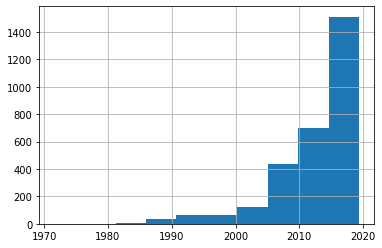

In [50]:
df.HIRE_DT.hist();